# Ukraine - Russia Conflict

In [64]:
import numpy as np
import pandas as pd

## Data Background

The chosen data is a related data set to the given Ukrainian conflict data set, however it differs slightly as our data focuses primarily on the daily events of the conflict and highlights the specifics of each interaction. Each event is provided an Event ID (event_id_cnty) and records a wide arrange of event-specific information that includes, but is not limited to, the date, classification, actors, location, and any casualties that may have occurred. The data ranges from 1/1/2020 to 10/23/2024 and is recorded daily. Multiple events can occur across the same day, but each individual event is recorded independently.

The data was recorded by the ACLED (Armed Conflict Location and Event Data), an “independent, impartial conflict monitor providing real-time data and analysis on violent conflict and protest in all countries and territories across the world”, per their website. ACLED is a registered non-profit that receives funding from the United Nations’ Complex Risk Analysis Fund. The validity and veracity of the data is extremely high.

The primary limitation of the data set lies in the handful of missing values. With 21 days missing from the dataset across the roughly four years of data, the process of modeling the Markov transitions had to be altered slightly in order to ensure the validity of the model. To alleviate this issue, the assumption that the missing days had no events or fatalities was made. This assumption was made after general research into the conflict and serves as the best alternative for the data constraints at hand. This allows for smoother, more accurate transitions in the Markov Chain modeling process and helps improve overall performance.


## 1. Prep Data

### a. Load Data

In [65]:
ukraine_events = pd.read_csv('data/ukraine-events.csv')

# add columns
ukraine_events["aggr_is_military"] = ukraine_events['actor1'].str.startswith('Military')
ukraine_events["def_is_military"] = ukraine_events['actor2'].str.startswith('Military')

ukraine_events['aggr_military'] = np.select(
    condlist = [
        ukraine_events['actor1'].str.contains('Ukraine', case=False, na=False) &
        ukraine_events['actor1'].str.contains('military', case=False, na=False),

        ukraine_events['actor1'].str.contains('Russia', case=False, na=False) &
        ukraine_events['actor1'].str.contains('military', case=False, na=False)
    ], choicelist = [
        'Ukraine',
        'Russia'
    ], default = None
)
ukraine_events['def_military'] = np.select(
    condlist = [
        ukraine_events['actor2'].str.contains('Ukraine', case=False, na=False) &
        ukraine_events['actor2'].str.contains('military', case=False, na=False),

        ukraine_events['actor2'].str.contains('Russia', case=False, na=False) &
        ukraine_events['actor2'].str.contains('military', case=False, na=False)
    ], choicelist = [
        'Ukraine',
        'Russia'
    ], default = None
)
ukraine_events['military_interaction'] = ukraine_events['aggr_military'].astype(str) + '-' + ukraine_events['def_military'].astype(str)


### b. Limit to Military Events

In [66]:
military_events = ukraine_events.query('aggr_is_military == True & sub_event_type in ["Armed clash", "Air/drone strike", "Shelling/artillery/missile attack", "Disrupted weapons use"]').reset_index()

### c. Modify Admin1 to be Location if Missing

In [67]:
military_events['admin1'] = military_events['admin1'].fillna(military_events['location'])

## 2. Data Checks

### a. Date is Continuous?

In [68]:
dates = pd.to_datetime(military_events['event_date']).reset_index()
dates['date_diff'] = dates['event_date'].diff()
is_continuous = (dates['date_diff'].iloc[1:] == pd.Timedelta(days=1)).all() or (dates['date_diff'].iloc[1:] == pd.Timedelta(days=0)).all()
if is_continuous:
    print("The date column contains a continuous list of dates.")
else:
    print("The date column does NOT contain a continuous list of dates.")

The date column does NOT contain a continuous list of dates.


In [69]:
non_continuous_dates = dates[dates['date_diff'] > pd.Timedelta(days=1)]
non_continuous_dates

,index,event_date,date_diff
4057,4057,2020-08-02,2 days
4062,4062,2020-08-05,2 days
4064,4064,2020-08-07,2 days
4076,4076,2020-08-13,2 days
4086,4086,2020-08-18,2 days
4094,4094,2020-08-22,2 days
4095,4095,2020-08-24,2 days
4098,4098,2020-08-26,2 days
4099,4099,2020-08-28,2 days
4103,4103,2020-09-01,3 days


### b. Missing Values?

In [70]:
military_events[military_events['admin1'].isnull()][['country', 'admin1', 'admin2', 'admin3', 'location']]['location'].value_counts()

Series([], Name: count, dtype: int64)

## 3. General Markov Chain Class

We will be creating Markov transition models for this analysis. We want to look at the locations that events occur in as one Markov chain, and the daily total fatalities as another Markov chain.

In [71]:
class MarkovChain:
    def __init__(self, sequence, title:str=None):
        self.sequence = sequence
        self.states = sorted(list(set(sequence)))
        self.tr_counts = self.create_transition_counts()
        self.tr_probs = self.create_transtion_probabilities()
        
        self.title = title
    
    def create_transition_counts(self):
        num_states = len(self.states)
        transition_counts = np.zeros( (num_states, num_states) )
        # dict_test = {str(x): {} for x in taxi_states}

        for i in range(len(self.sequence)-1):
            from_state = self.sequence[i]
            to_state = self.sequence[i+1]

            from_index = self.states.index(from_state)
            to_index = self.states.index(to_state)
            
            transition_counts[from_index][to_index] += 1

        return transition_counts
    
    def create_transtion_probabilities(self):
        transition_counts = self.tr_counts

        row_sums = transition_counts.sum(axis=1, keepdims=True) # axis=1 is rows; rows because we want sum of all counts FROM same state

        # Normalize the transition count matrix to get proportions:
        return np.divide(transition_counts, 
                        row_sums, 
                        out=np.zeros_like(transition_counts),
                        where=row_sums!=0)
    
    def graph_transitions(self):
        import seaborn as sns
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10,10))
        sns.heatmap(self.tr_probs, 
                    cmap='Blues',
                    square=True,          
                    xticklabels=self.states,
                    yticklabels=self.states,
                    cbar_kws={'label': 'Transition Probability'},
                    annot=True)

        plt.title('Transition Probabilities')
        if self.title is not None:
            plt.title(self.title)
        plt.xlabel('...To State')
        plt.ylabel('From State...')
        plt.show()

## 4. Max Events Location Markov

For the event locations Markov chain, we are fitting our data using consecutive days to see how location of events changes from day to day. 

In [72]:
daily_max_location = military_events.groupby('event_date')['admin1'].max().reset_index()

In [73]:
daily_max_location.head()

,event_date,admin1
0,2020-01-01,Luhansk
1,2020-01-02,Donetsk
2,2020-01-03,Luhansk
3,2020-01-04,Luhansk
4,2020-01-05,Luhansk


In [74]:
# Ensure 'event_date' is datetime
daily_max_location['event_date'] = pd.to_datetime(daily_max_location['event_date'])

# reindex to ensure all days included
df_reindexed = daily_max_location.set_index('event_date')
full_date_range = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='D')
df_reindexed = df_reindexed.reindex(full_date_range, fill_value="None")
df_reindexed = df_reindexed.reset_index().rename(columns={'index': 'event_date'})

# save as max location
daily_max_location = df_reindexed.copy()


In [75]:
daily_max_location['admin1'].value_counts()

admin1
Zaporizhia              869
Luhansk                 584
Donetsk                 177
Zhytomyr                 97
None                     21
Sumy                      5
Republic of Dagestan      2
Primorskiy                1
Odesa                     1
Poltava                   1
Name: count, dtype: int64

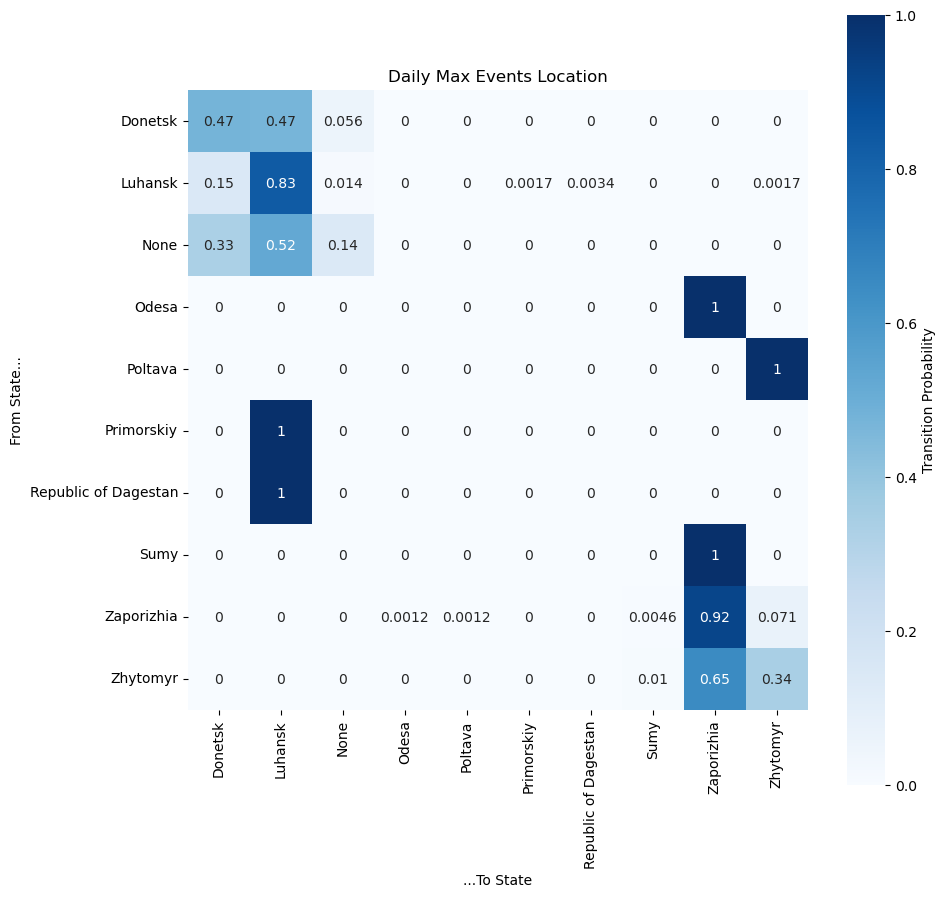

In [76]:
location_daily_max_markov = MarkovChain(daily_max_location['admin1'], title='Daily Max Events Location')
location_daily_max_markov.graph_transitions()

When military events occurred in Donetsk, Luhansk, Zaporizhia, or Zhytomyr, they often occurred again in that same location on the next day. We can make the assumption that most events occurred in these 4 locations, based on the numbers shown above. When an event occurs in Donetsk, it is equally likely to occur there next as it is to occur in Luhansk. When an event occurs in Zhytomyr, it is also very likely that it will occur in Zaporizhia or the same place again the next day. This highlights the potential link between these two pairs of locations when it comes to military events.

A challenge faced when fitting this model was that the distribution of events in each location is so uneven that the visualization itself cannot tell us the full story. For example, from Primorskiy to Luhansk shows a 1.0 transition probability, which could cause us to think this connection between these two locations is very strong. However, there is only 1 event in Primorskiy in the data set, so this 1.0 really does not have much statistical significance. When looking at this visualization, we also must factor in the value counts calculated previously to make meaningful inferences.

## 5. Total Daily Fatalities Markov

For the daily fatalities Markov chain, we are fitting our data using consecutive days to see how the number of fatalities changes day to day.

In [77]:
total_daily_fatalities = military_events.groupby('event_date')['fatalities'].sum().reset_index()
total_daily_fatalities['fatality_level'] = pd.cut(total_daily_fatalities['fatalities'], bins=[-1, 0, 100, 200, 300, float('inf')], labels=['0', '1-100', '101-200', '201-300', '301+'])
total_daily_fatalities['fatality_level'].value_counts()

fatality_level
0          699
1-100      552
101-200    306
201-300    105
301+        75
Name: count, dtype: int64

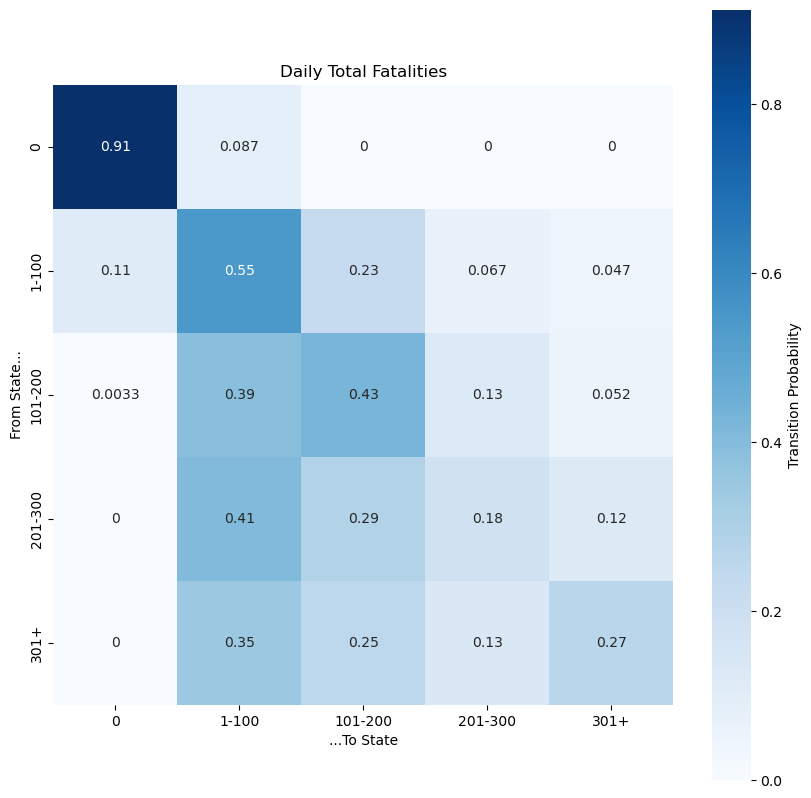

In [ ]:
fatality_daily_max_markov = MarkovChain(total_daily_fatalities['fatality_level'], title='Daily Total Fatalities')
fatality_daily_max_markov.graph_transitions()

The graph above shows the Markov transition model for daily total fatalities, so we can see if a spike in fatalities stays relatively high over the next few days, or if this volatility is more sudden. Here, we can see that most days that have 0 military fatalities also have 0 the next day. There is never a jump from 0 fatalities to 301+ fatalities. Furthermore, we see a general gradient as we ascend in number of fatalities, highlighting that a spike in the number of fatalities does not happen in one day, but rather increases gradually. We observed a similar result in the reverse direction. When there are 301+ fatalities in one day, the next day never showed 0 fatalities. However, it is interesting to note that most days that do have fatalities fall into the 1-100 bucket, and the gradients described tend to converge around this measure. This suggests that these higher numbers of fatalities are more so outliers, although the gradient concept is still relevant.

A challenge faced when fitting this model was interpreting the distribution of transition probabilities across the matrix. Since most nonzero values fall into the 1-100 bucket, it is more useful to look at the distribution of the remaining probabilities in conjunction with the 1-100 probability, and not only at that column. Doing this allowed us to hypothesize about these more gradual volatility spikes that we previously described.


## 6. Create New Sequences

In [ ]:
def simulate_markov_chain(mc, n_steps=20, seed=100):
    np.random.seed(seed)
    
    states = mc.states
    tr_probs = mc.tr_probs
    
    initial_state = np.random.choice(states)
    state_index = states.index(initial_state)
    
    simulation = [initial_state]
    
    for _ in range(n_steps-1):
        pr_t = tr_probs[state_index]
        state_index = np.random.choice(len(states), p=pr_t)
        simulation.append(states[state_index])
    
    return simulation

In [ ]:
# Simulate 30 days of max-event locations
simulated_locations = simulate_markov_chain(location_daily_max_markov, n_steps=30, seed=101)
print("Simulated Daily Max Event Locations:")
print(simulated_locations)

In [ ]:
# Simulate 30 days of total daily fatality levels
simulated_fatalities = simulate_markov_chain(fatality_daily_max_markov, n_steps=30, seed=202)
print("Simulated Daily Total Fatality Levels:")
print(simulated_fatalities)